In [2]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2,plot_kde_matrix_for_paper
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel, plot_kde_matrix
import numpy as np
import matplotlib.pyplot as plt

path = '/Users/adsurbum/sim-data/single-model-abc/new4'
output_path = '../../figures'

f_no_aneuploidy = '2021-12-29-no-aneuploidy'
f_with_aneuploidy = '2021-12-29-an200-k1'

## Instruction
### You can jump [loading section](#loading) if you want only to plot figure and the data is already persisted

In [79]:
def MAP(f):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
    samples, weights = history.get_distribution(m=0, t=None)
    columns = list(samples.columns)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(), weights=weights)
    size = 50000
    samples = kde.resample(size).T
    samples = pd.DataFrame(data=samples,columns=columns)
    MAP = scipy.optimize.minimize(lambda x: -kde.logpdf(x) ,samples.median().values)['x']
    return MAP

In [80]:
import sys  
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1, stopon=3000, fixation=0.95)
N = 6*10**6
reps = 10000

## MAP of model with aneuploidy

In [25]:
%%time
p = MAP(f_with_aneuploidy)
p = [p[0],p[1],p[1],*p[2:]] # aneuploidy gain and loss rates are the same
times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
model.grade_function2(times_p)

CPU times: user 6min 47s, sys: 8 s, total: 6min 55s
Wall time: 7min 45s


-0.8430105411473439

In [26]:
with_aneuploidy = times_p

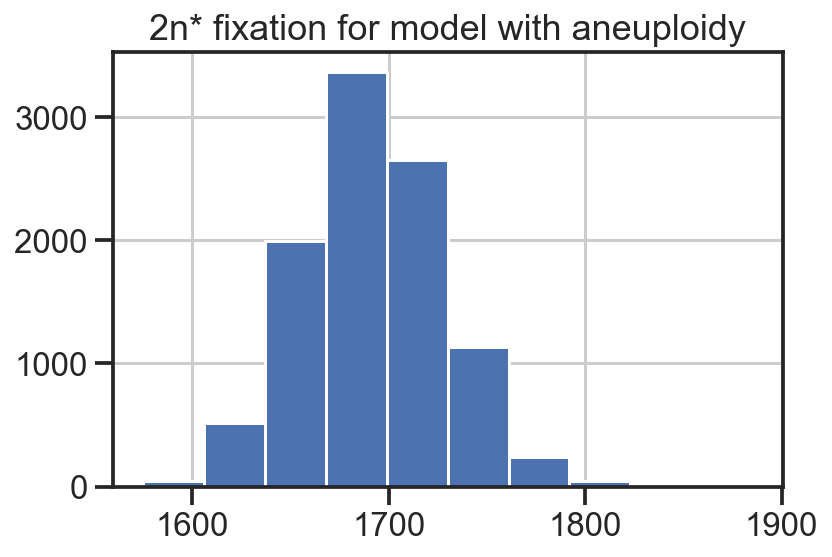

In [27]:
pd.Series(times_p[0]).hist()
plt.title('2n* fixation for model with aneuploidy');

## MAP of model with aneuploidy and delta=0

In [28]:
p = MAP(f_with_aneuploidy)
p = [p[0],0,0,*p[2:]]
times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
model.grade_function2(times_p)

0

In [29]:
with_aneuploidy_delta0 = times_p

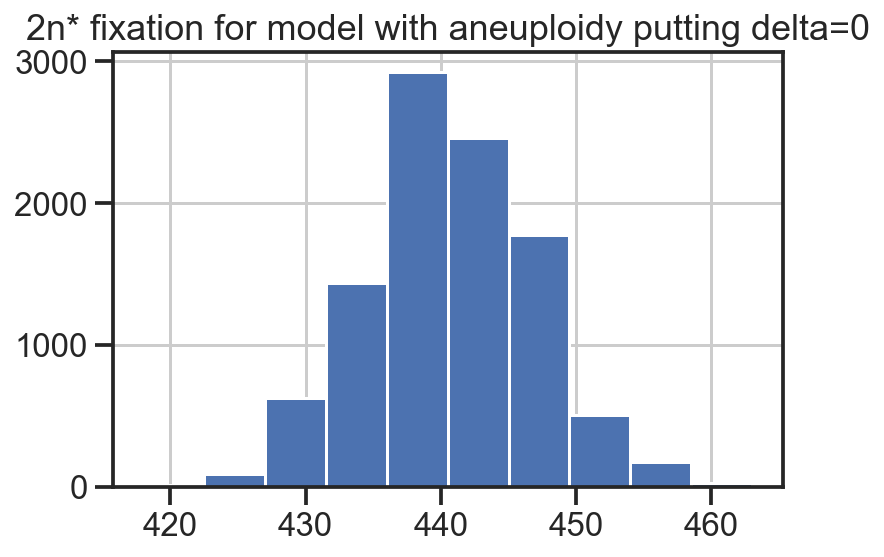

In [30]:
pd.Series(times_p[0]).hist()
plt.title('2n* fixation for model with aneuploidy putting delta=0');

## MAP of model *without* aneuploidy

In [31]:
p = MAP(f_no_aneuploidy) #mutation rate and w(2n*)
p = [p[0],0,0,0,0,p[-1]]
times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
model.grade_function2(times_p)

0

In [41]:
model.grade_function_no_aneuploidy(times_p)

-0.6717966270529023

In [32]:
no_aneuploidy = times_p

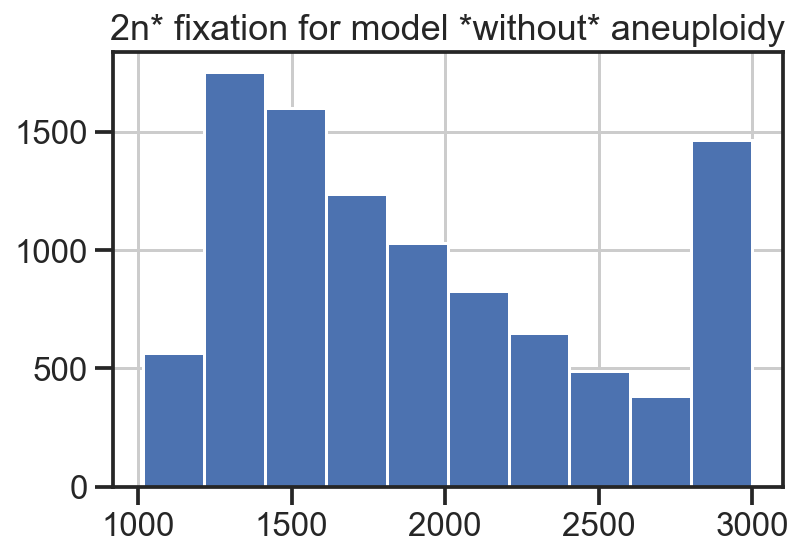

In [33]:
pd.Series(times_p[0]).hist()
plt.title('2n* fixation for model *without* aneuploidy');

## Persisting result
### uncomment the next line if you need it

In [38]:

# np.savez_compressed('./outputs/with-aneuploidy_vs_no-aneuploidy',with_aneuploidy=with_aneuploidy, 
#                     with_aneuploidy_delta0=with_aneuploidy_delta0, no_aneuploidy=no_aneuploidy)

<a id='loading'></a>

## Loading persisted
### uncomment the next cell if needed

In [3]:
loaded = np.load('./outputs/with-aneuploidy_vs_no-aneuploidy.npz',allow_pickle=True)
with_aneuploidy, with_aneuploidy_delta0, no_aneuploidy = loaded['with_aneuploidy'], loaded['with_aneuploidy_delta0'], loaded['no_aneuploidy']

no trisomy at 450: 0 of  10000
450<F<1700 6133
1700<F<2350 3867
F>2350 0
test: True


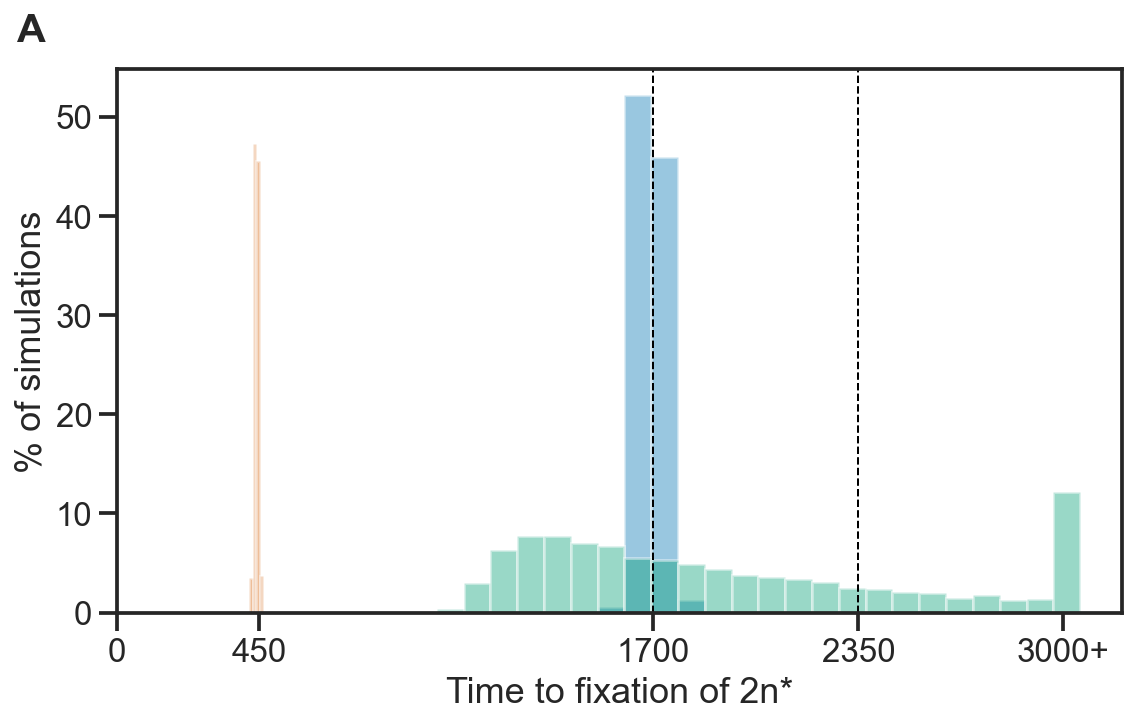

In [18]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 2.5, 'lines.markersize': 7})
blue,yellow,green,red,pink,brown,pink2,grey = sns.color_palette("colorblind", 8)

def plot(withaneuploidy, withaneuploidy_delta0, no_aneuploidy, bins, norm_hist, stopon=10000, reps=10_000):
    if withaneuploidy is not None:
        times,p = withaneuploidy
        nparr = np.array(p)
        l = nparr[:,1][:,].shape[1]
        trifixtimes = [next((i for i,p in enumerate(nparr[:,1][:,j]) if p>=0.95),stopon) for j in  range(l)]

        a1 = l-len([(tri,plus) for plus, tri in zip(times,trifixtimes) if tri<=450 and tri>200 and plus>450])
        a2 = len([(tri,plus) for plus, tri in zip(times,trifixtimes) if tri<=450 and tri>200 and plus<=1700 and plus>450])
        a3 = len([(tri,plus) for plus, tri in zip(times,trifixtimes) if tri<=450 and tri>200 and plus<=2350 and plus>1700])
        a4 = len([(tri,plus) for plus, tri in zip(times,trifixtimes) if tri<=450 and tri>200 and plus>2350])
        print('no trisomy at 450:', a1,'of ',l)
        print('450<F<1700',a2)
        print('1700<F<2350',a3)
        print('F>2350',a4)
        print('test:',l-a2-a3-a4==a1)

    plt.subplots(figsize=(9, 5))
    ax = plt.axes()
    if withaneuploidy is not None:
        sns.distplot([plus for plus, tri in zip(times,trifixtimes) if tri<=450 and plus>450 and plus<stopon], rug=False, 
                     kde=False,ax=ax,color=blue,bins=bins[0], 
                    rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist, label='With aneuploidy model MAP')
    if no_aneuploidy is not None:
        sns.distplot([t for t in no_aneuploidy[0] if t<stopon], rug=False, 
                    kde=False,ax=ax,color=green,bins=bins[1], 
                rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist, label='No aneuploidy model MAP')
    if withaneuploidy_delta0 is not None:
        sns.distplot([t for t in withaneuploidy_delta0[0] if t<stopon], rug=False, 
                kde=False,ax=ax,color=red,bins=bins[2], 
            rug_kws={"color": "gray","height":"0.03"}, norm_hist=norm_hist, label='With aneuploidy model MAP, $\delta=0$')
      
    ax.axvline(1700,color='black',linestyle='--',linewidth=1)
    ax.axvline(2350,color='black',linestyle='--',linewidth=1)
    
    ax.set(xlabel='Time to fixation of 2n*', 
           ylabel='% of simulations')
    
#     plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.75), fontsize=16)

    ax.set_xticks([0,450,1700,2350,3000])
    ax.set_xticklabels([0,450,1700,2350,'3000+'])
    ax.set_xlim(left = 0) # is it good to start from 0?
    ax.set_yticklabels((100*ax.get_yticks()/reps).astype(int)) # convert to percents
    ax.text(-0.1, 1.05, 'A', transform=ax.transAxes, size=20, weight='bold')
    
b = [t for t in no_aneuploidy[0]]
c = [t for t in with_aneuploidy_delta0[0]]
minn = int(min(min(b),min(c)))
maxx = int(max(max(b),max(c)))
width = 85
bins = list(range(minn,maxx+width,width))
plot(with_aneuploidy, with_aneuploidy_delta0, no_aneuploidy, [bins,bins,4], False, stopon=3000)
plt.gcf().savefig(f'{output_path}/fixation-plot-a.pdf', bbox_inches='tight')

## another figure

In [10]:
reps = 10000
times, p = with_aneuploidy
fixation_progress_with = [len([b for b in a if b>0.95])/reps for a in np.array(p)[:,3][:3000,]]
if len(fixation_progress_with)!=3000:
    fixation_progress_with = fixation_progress_with+[fixation_progress_with[-1]]*(3000-len(fixation_progress_with))

In [13]:
times, p = no_aneuploidy
fixation_progress_without = [len([b for b in a if b>0.95])/reps for a in np.array(p)[:,3][:3000,]]
if len(fixation_progress_without)!=3000:
    fixation_progress_without = fixation_progress_without+[fixation_progress_without[-1]]*(3000-len(fixation_progress_without))

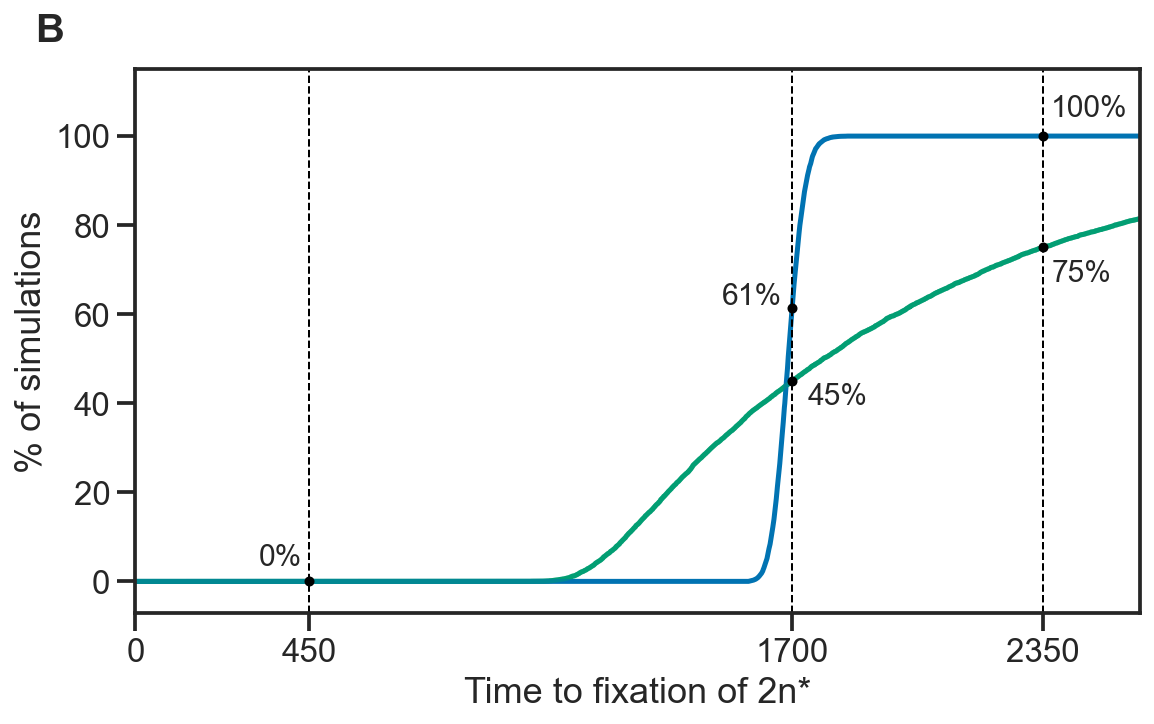

In [19]:
import seaborn as sns

blue,yellow,green,red,pink,brown,pink2,grey = sns.color_palette("colorblind", 8)

def plot_accumulated_fixation(progress, progress2):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(range(len(progress2)), progress2, label='No aneuploidy model MAP', color=green)
    ax.plot(range(len(progress)), progress, label='With aneuploidy model MAP', color=blue)
    ax.plot(range(len(progress2)), progress2, color=green, alpha=0.5)

    ax.axvline(450,linestyle='--',linewidth=1,color="black")
    ax.axvline(1700,linestyle='--',linewidth=1,color="black")
    ax.axvline(2350,linestyle='--',linewidth=1,color="black")
       
    annot_font_size = 15
    plt.plot(450,progress[450],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress[450]*100),(450,progress[450]),(-25,8),textcoords='offset points',fontsize=annot_font_size)
    plt.plot(1700,progress[1700],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress[1700]*100),(1700,progress[1700]),(-35,2),textcoords='offset points',fontsize=annot_font_size)
    plt.plot(2350,progress[2350],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress[2350]*100),(2350,progress[2350]),(4,10),textcoords='offset points',fontsize=annot_font_size)
    
    plt.plot(1700,progress2[1700],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress2[1700]*100),(1700,progress2[1700]),(8,-12),textcoords='offset points',fontsize=annot_font_size)
    plt.plot(2350,progress2[2350],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress2[2350]*100),(2350,progress2[2350]),(4,-17),textcoords='offset points',fontsize=annot_font_size)

    plt.xlim(0,2600)
    plt.ylim(-0.07,1.15)
    
    import matplotlib.ticker as mtick
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_yticklabels([int(a) for a in 100*ax.get_yticks()]) # convert to percents
    ax.set_xticks([0,450,1700,2350])

    ax.set(xlabel='Time to fixation of 2n*', ylabel='% of simulations')
#     plt.legend(*(
#         [ x[i] for i in [1,0] ]
#         for x in plt.gca().get_legend_handles_labels()),
#                loc='upper right', bbox_to_anchor=(1.55, 0.75), fontsize=16)
    
    ax.text(-0.1, 1.05, 'B', transform=ax.transAxes, size=20, weight='bold')

    
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 2.5, 'lines.markersize': 4})

plot_accumulated_fixation(fixation_progress_with, fixation_progress_without)
plt.gcf().savefig(f'{output_path}/fixation-plot-b.pdf', bbox_inches='tight',)